# Analysis of CBRAIN-CAM online runs

Goal: Get a standard set of analysis for online runs and compare to reference runs

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def gw_avg(ds, var):
    return (ds[var] * ds['gw'].values).mean(dim=('lat', 'lon'))

In [10]:
def animate_lat_lon(a, interval=100, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    I = ax.imshow(a[1], **kwargs)
    cb = fig.colorbar(I, ax=ax, shrink=0.7)
    T = ax.set_title(f'Step 1')
    def update(i):
        T.set_text(f'Step {i}')
        I.set_data(a[i])
        return I,
    plt.close(fig)
    return FuncAnimation(fig, update, frames=np.arange(1, a.shape[0]), interval=interval, blit=True)

In [67]:
DATA_DIR = '/scratch/05488/tg847872/E002_fullphy_fbp32/'
SP_DIR = '/scratch/05488/tg847872/galen_sp/'
NONSP_DIR = '/scratch/05488/tg847872/galen_nonsp/'

In [75]:
%%time
dcbrain = xr.open_mfdataset(f'{DATA_DIR}AndKua*.h1.0000-0[2-9]*.nc', decode_times=False, decode_cf=False); 

CPU times: user 7.79 s, sys: 1.13 s, total: 8.92 s
Wall time: 3min 5s


In [76]:
%%time
dsp = xr.open_mfdataset(f'{SP_DIR}AndKua*.h1.0000-0[2-9]*.nc', decode_times=False, decode_cf=False);

CPU times: user 6.77 s, sys: 918 ms, total: 7.69 s
Wall time: 2min 56s


In [77]:
%%time
dnonsp = xr.open_mfdataset(f'{NONSP_DIR}AndKua*.h1.0000-0[2-9]*.nc', decode_times=False, decode_cf=False);

CPU times: user 5.82 s, sys: 970 ms, total: 6.79 s
Wall time: 3min 15s


In [19]:
def plot_comparison(var, t, ds=None, lev=slice(0, None), lon=slice(0, None), **kwargs):
    fig, axes = plt.subplots(1, 3, figsize = (15,4))
    if ds is None: ds = [dcbrain, dsp, dnonsp]
    for ax, d in zip(axes.flat, ds):
        d.isel(lon=lon, lev=lev, time=t)[var].plot(ax=ax, add_colorbar=False, **kwargs)

## Mean state
Ignoring first month of spin-up. Month 2 - 10.

In [20]:
sl = slice(0, 48*30*9, 48)

In [21]:
len(range(0, 48*30*9, 48))

270

### Mean T, Q, TPHYSTND, PHQ

In [22]:
def comp_mean(d, var, sl):
    return d[var].isel(time=sl).mean('time')

In [78]:
TAPmeans = [comp_mean(d, 'TAP', sl).compute() for d in [dcbrain, dsp, dnonsp]]

In [79]:
QAPmeans = [comp_mean(d, 'QAP', sl).compute() for d in [dcbrain, dsp, dnonsp]]

In [80]:
TPHYSTNDmeans = [comp_mean(d, 'TPHYSTND', sl).compute() for d in [dcbrain, dsp, dnonsp]]
PHQmeans = [comp_mean(d, 'PHQ', sl).compute() for d in [dcbrain, dsp, dnonsp]]

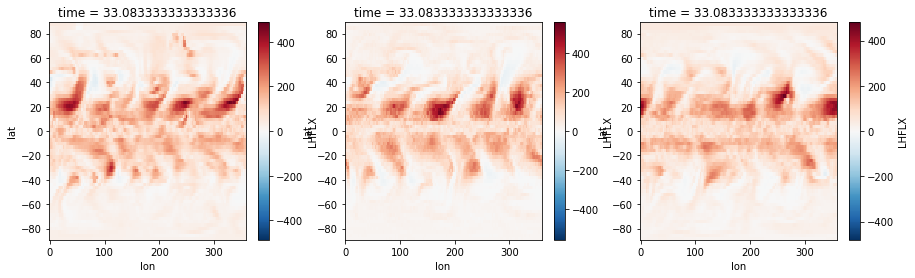

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
[da.LHFLX.isel(time=100
              ).plot(ax = ax) for ax, da in zip(axes.flat, [dcbrain, dsp, dnonsp])];

In [82]:
def plot_mean_diff(means, **kwargs):
    fig, axes = plt.subplots(1, 3, figsize = (15,4))
    means[1].mean('lon').plot(ax=axes[0], yincrease=False)
    (means[0] - means[1]).mean('lon').plot(ax=axes[1], yincrease=False, **kwargs)
    (means[2] - means[1]).mean('lon').plot(ax=axes[2], yincrease=False, **kwargs)

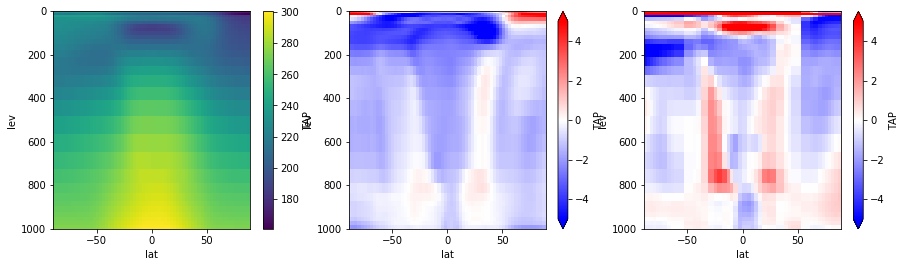

In [83]:
plot_mean_diff(TAPmeans, vmin=-5, vmax=5, cmap='bwr')

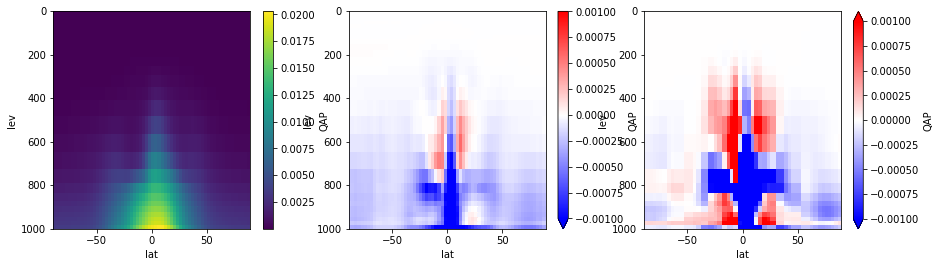

In [84]:
plot_mean_diff(QAPmeans, vmin=-1e-3, vmax=1e-3, cmap='bwr')

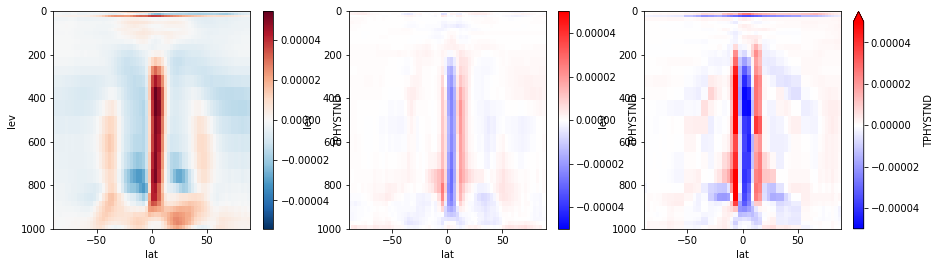

In [85]:
plot_mean_diff(TPHYSTNDmeans, vmin=-5e-5, vmax=5e-5, cmap='bwr')

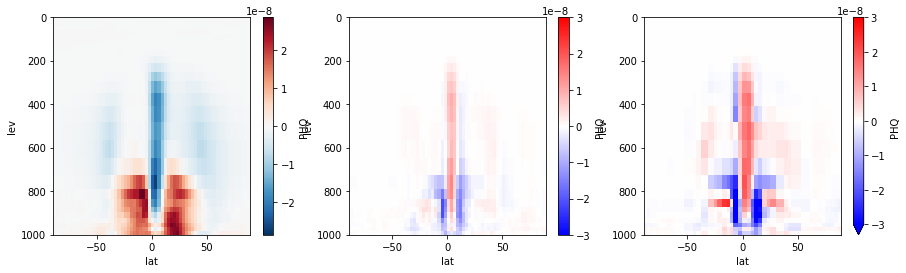

In [86]:
plot_mean_diff(PHQmeans, vmin=-3e-8, vmax=3e-8, cmap='bwr')

### Mean vertically integrated TPHYSTND (something like precip)

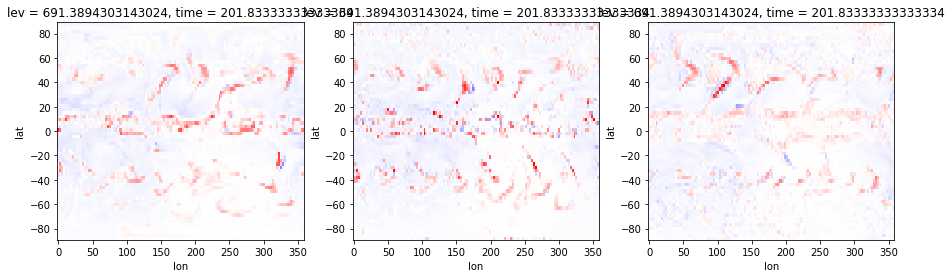

In [36]:
plot_comparison('TPHYSTND', 1000, lev=20, vmin=-5e-4, vmax=5e-4, cmap='bwr')

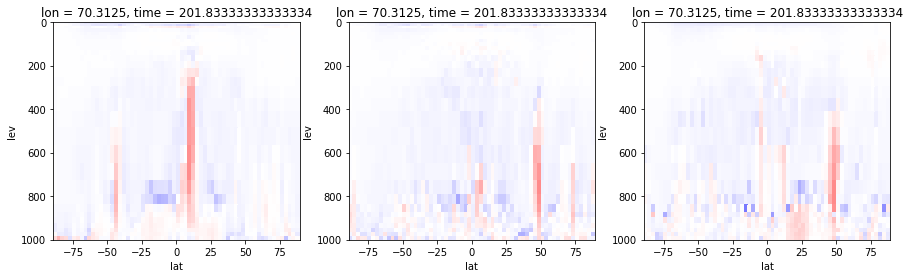

In [35]:
plot_comparison('TPHYSTND', 1000, lon=25, vmin=-5e-4, vmax=5e-4, cmap='bwr', yincrease=False)

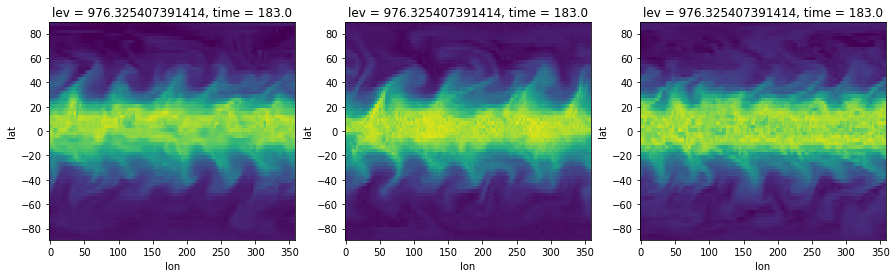

In [47]:
plot_comparison('QAP', 48*2, lev=28, vmax=0.02, vmin=0.002)

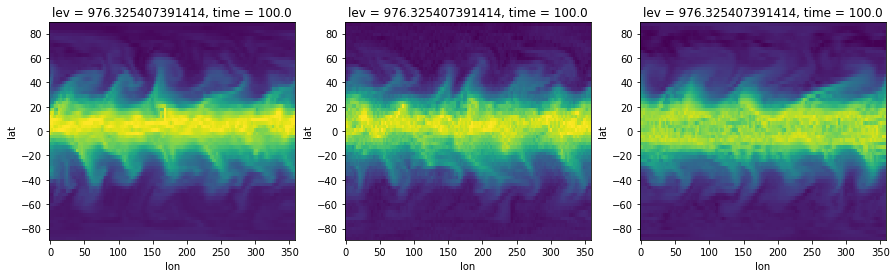

In [85]:
plot_comparison('QAP', 48*100, 28, vmax=0.02, vmin=0.002)

In [37]:
dcbrain['vintTPHYSTND'] = vint(dcbrain, 'TPHYSTND', C_P)
dsp['vintTPHYSTND'] = vint(dsp, 'TPHYSTND', C_P)
dnonsp['vintTPHYSTND'] = vint(dnonsp, 'TPHYSTND', C_P)

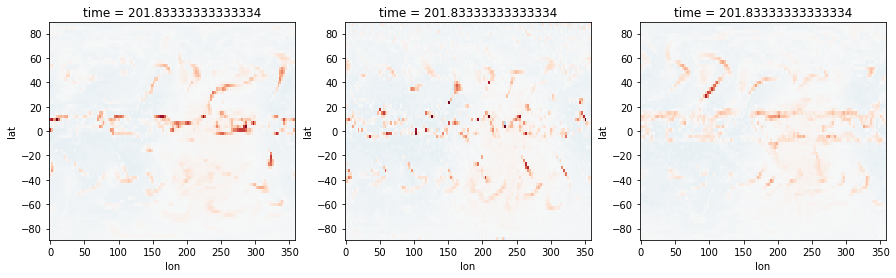

In [39]:
plot_comparison('vintTPHYSTND', 1000, vmin=-3e3, vmax=3e3, cmap='RdBu_r')

In [118]:
dcbrain['vintTAP'] = vint(dcbrain, 'TAP', C_P)
dsp['vintTAP'] = vint(dsp, 'TAP', C_P)
dnonsp['vintTAP'] = vint(dnonsp, 'TAP', C_P)

In [119]:
dcbrain['gwvintTAP'] = gw_avg(dcbrain, 'vintTAP')
dsp['gwvintTAP'] = gw_avg(dsp, 'vintTAP')
dnonsp['gwvintTAP'] = gw_avg(dnonsp, 'vintTAP')

In [120]:
dcbrain['gwvintTAP']

<xarray.DataArray 'gwvintTAP' (time: 14854)>
dask.array<shape=(14854,), dtype=float64, chunksize=(48,)>
Coordinates:
  * time     (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 0.125 ...

KeyboardInterrupt: 

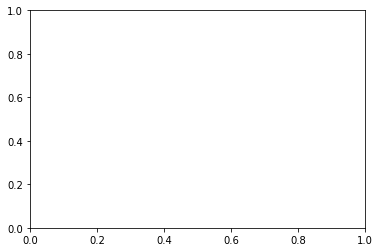

In [133]:
dcbrain['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='CBRAIN')
dsp['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='SP')
dnonsp['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='nonSP')
plt.legend();

In [40]:
def mean_ts(ds): return (ds['TAP'].isel(lev=-1) * ds['gw'] / ds['gw'].mean()).mean(('lat', 'lon'))

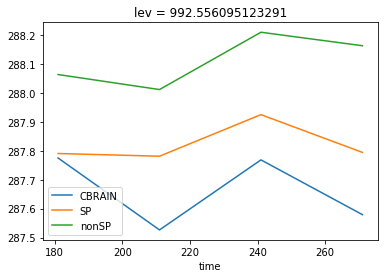

In [41]:
mean_ts(dcbrain.isel(time=slice(1, None, 48*30))).plot(label='CBRAIN')
mean_ts(dsp.isel(time=slice(1, None, 48*30))).plot(label='SP')
mean_ts(dnonsp.isel(time=slice(1, None, 48*30))).plot(label='nonSP')
plt.legend();

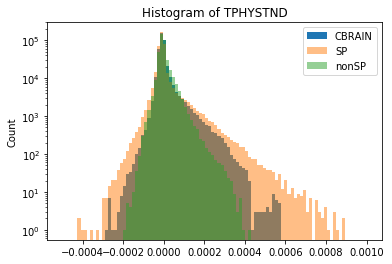

In [42]:
dcbrain['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

In [44]:
dcbrain['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

IndexError: index 9696 is out of bounds for axis 1 with size 4416

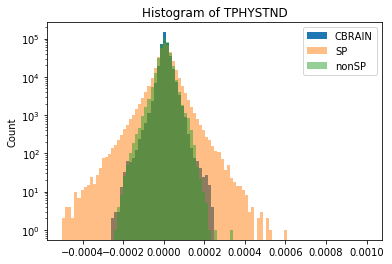

In [155]:
dcbrain['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

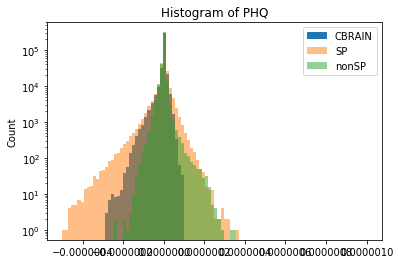

In [45]:
dcbrain['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

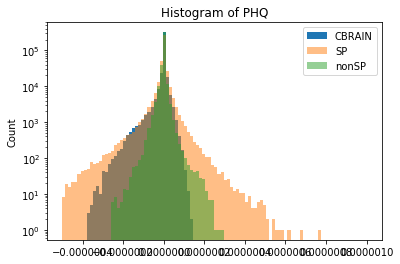

In [151]:
dcbrain['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

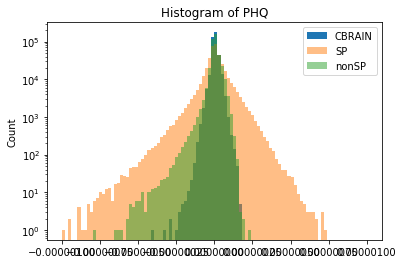

In [153]:
dcbrain['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

In [12]:
anim = animate_lat_lon(
    dcbrain['TPHYSTND'].isel(lev=20, time=range(0, 48*5, 4)), 
    125, vmin=-7e-4, vmax=7e-4, cmap='bwr'
)

In [14]:
HTML(anim.to_html5_video())

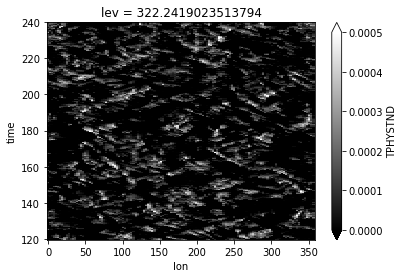

In [130]:
dsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

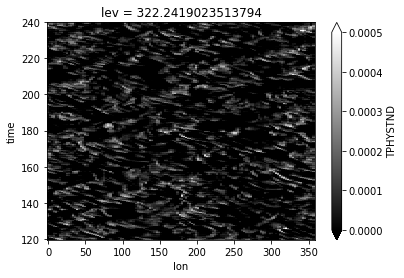

In [131]:
dcbrain['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

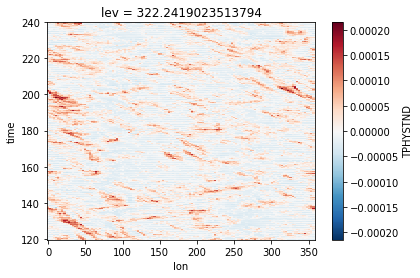

In [127]:
dnonsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(0, 10)).mean('lat').plot()

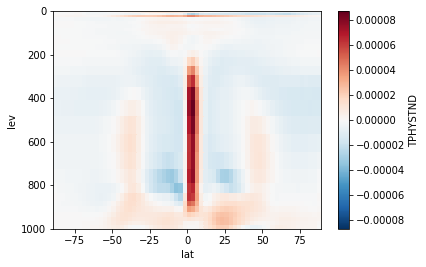

In [121]:
TPHYSTNDmeans[0].mean('lon').plot(yincrease=False)

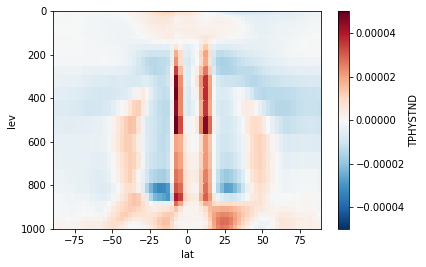

In [128]:
TPHYSTNDmeans[2].mean('lon').plot(yincrease=False)

In [94]:
tmp = xr.open_dataset('/scratch/05488/tg847872/sp8fbp_andkua/sp8fbp_andkua.cam2.h1.0000-01-01-00000.nc',
                     decode_times=False)

In [96]:
tmp.time

<xarray.DataArray 'time' (time: 13)>
array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125,
       1.25 , 1.375, 1.5  ])
Coordinates:
  * time     (time) float64 0.0 0.125 0.25 0.375 0.5 0.625 0.75 0.875 1.0 ...
Attributes:
    long_name:  time
    units:      days since 0000-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bnds

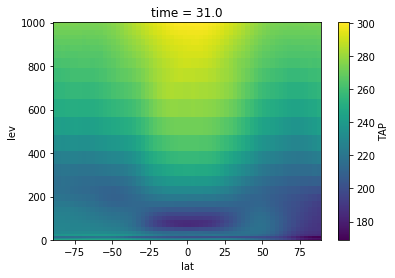

In [91]:
tmp.TAP.mean('lon').plot()